This notebook is an upgrade of the first one. Here, we already have some sampling strategy (preliminar) for the training and testing datasets. Then, the torch Dataset and Dataloder were modified

In [2]:
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import geopandas as gpd
import wandb
import matplotlib.pyplot as plt
import h5py
import time

In [3]:
torch.cuda.is_available()

True

In [4]:
with open("/media/daniel/7C42A09342A05424/Users/morae/Desktop/DGT/IFN/Classificacao2023/band_names.npy", 'rb') as f:
    aux = np.load(f)

In [5]:
sel_bands = [
'S2X_L2A_composite_median_20221001_20221031_Portugal.1',
'S2X_L2A_composite_median_20221001_20221031_Portugal.2',
'S2X_L2A_composite_median_20221001_20221031_Portugal.3',
'S2X_L2A_composite_median_20221001_20221031_Portugal.7',
'S2X_L2A_composite_median_20221001_20221031_Portugal.9',
'S2X_L2A_composite_median_20221001_20221031_Portugal.10',

'S2X_L2A_composite_median_20230101_20230131_Portugal.1',
'S2X_L2A_composite_median_20230101_20230131_Portugal.2',
'S2X_L2A_composite_median_20230101_20230131_Portugal.3',
'S2X_L2A_composite_median_20230101_20230131_Portugal.7',
'S2X_L2A_composite_median_20230101_20230131_Portugal.9',
'S2X_L2A_composite_median_20230101_20230131_Portugal.10',

'S2X_L2A_composite_median_20230401_20230430_Portugal.1',
'S2X_L2A_composite_median_20230401_20230430_Portugal.2',
'S2X_L2A_composite_median_20230401_20230430_Portugal.3',
'S2X_L2A_composite_median_20230401_20230430_Portugal.7',
'S2X_L2A_composite_median_20230401_20230430_Portugal.9',
'S2X_L2A_composite_median_20230401_20230430_Portugal.10',

'S2X_L2A_composite_median_20230701_20230731_Portugal.1',
'S2X_L2A_composite_median_20230701_20230731_Portugal.2',
'S2X_L2A_composite_median_20230701_20230731_Portugal.3',
'S2X_L2A_composite_median_20230701_20230731_Portugal.7',
'S2X_L2A_composite_median_20230701_20230731_Portugal.9',
'S2X_L2A_composite_median_20230701_20230731_Portugal.10',

'S2X_L2A_composite_median_20221001_20221031_Portugal_NDVI',
'S2X_L2A_composite_median_20221101_20221130_Portugal_NDVI',
'S2X_L2A_composite_median_20221201_20221231_Portugal_NDVI',
'S2X_L2A_composite_median_20230101_20230131_Portugal_NDVI',
'S2X_L2A_composite_median_20230201_20230228_Portugal_NDVI',
'S2X_L2A_composite_median_20230301_20230331_Portugal_NDVI',
'S2X_L2A_composite_median_20230401_20230430_Portugal_NDVI',
'S2X_L2A_composite_median_20230501_20230531_Portugal_NDVI',
'S2X_L2A_composite_median_20230601_20230630_Portugal_NDVI',
'S2X_L2A_composite_median_20230701_20230731_Portugal_NDVI',
'S2X_L2A_composite_median_20230801_20230831_Portugal_NDVI',
'S2X_L2A_composite_median_20230901_20230930_Portugal_NDVI'
]

band_indices = []
for i, b in enumerate(aux):
    if b in sel_bands:
        band_indices.append(i)

In [3]:
# #concatenate the hdf5 files from 4 tiles
# import os
# tiles = ['T29SNB','T29SNC','T29TNE','T29TPF']
# base_path = "/media/daniel/7C42A09342A05424/Users/Pedro_DGT.DANIEL-PC/Compositos_2023"

# out_file = "/media/daniel/7C42A09342A05424/Users/Pedro_DGT.DANIEL-PC/Compositos_2023/crops_train_all.hdf5" #change train/test and run

# with h5py.File(out_file, 'w') as out_f:
#     for tile in tiles:
#         file = os.path.join(base_path,tile,'composites/crops_train.hdf5') #change train/test and run
#         with h5py.File(file, 'r') as in_f:
#             # Iterate through items in the input file
#             for name, item in in_f.items():
#                 if isinstance(item, h5py.Dataset):
#                     # If the item is a dataset, copy it to the output file
#                     in_f.copy(item, out_f, name=name)
#                 elif isinstance(item, h5py.Group):
#                     # If the item is a group, copy it recursively
#                     in_f.copy(item, out_f, name=name)
    

In [9]:
# #this was needed to address entries having shape different than (286,50,50) - probably due to border with the sea (nodata)
# with h5py.File("/media/daniel/7C42A09342A05424/Users/Pedro_DGT.DANIEL-PC/Compositos_2023/crops_test_all.hdf5", 'a') as f:
#     correct_shape=(286, 50, 50)
#     crop_keys = [key for key in f.keys() if key.startswith('crop_')]
#     label_keys = [key for key in f.keys() if key.startswith('label_')]

#     # Sort keys to ensure correct processing order
#     crop_keys.sort(key=lambda x: int(x.split('_')[-1]))
#     label_keys.sort(key=lambda x: int(x.split('_')[-1]))

#     correct_crop_keys = []
#     correct_label_keys = []

#     # Identify keys with correct shape
#     for crop_key in crop_keys:
#         if f[crop_key].shape == correct_shape:
#             correct_crop_keys.append(crop_key)
#             label_key = 'label_' + crop_key.split('_')[-1]
#             if label_key in f:
#                 correct_label_keys.append(label_key)

#     # Remove incorrect keys
#     all_keys = set(crop_keys + label_keys)
#     correct_keys = set(correct_crop_keys + correct_label_keys)
#     keys_to_remove = all_keys - correct_keys

#     for key in keys_to_remove:
#         del f[key]

#     # Renaming the keys to maintain continuous sequence
#     for new_idx, crop_key in enumerate(correct_crop_keys):
#         current_idx = int(crop_key.split('_')[-1])
#         if current_idx != new_idx:
#             new_crop_key = f"crop_{new_idx}"
#             new_label_key = f"label_{new_idx}"
#             old_label_key = f"label_{current_idx}"
            
#             # Renaming datasets
#             f[new_crop_key] = f[crop_key][:]
#             f[new_label_key] = f[old_label_key][()]
            
#             # Removing old datasets
#             del f[crop_key]
#             del f[old_label_key]

In [3]:
# #OLD CLASS, SLOWER
# class HDF5Dataset(Dataset):
#     def __init__(self, hdf5_path, transform=None):
#         self.hdf5_path = hdf5_path
#         self.transform = transform
#         with h5py.File(hdf5_path, 'r') as h5file:
#             self.keys = list(h5file.keys())
    
#     def __len__(self):
#         return len(self.keys) // 2  # Assuming pairs of crop and label
    
#     def __getitem__(self, idx):
#         with h5py.File(self.hdf5_path, 'r') as h5file:
#             crop = h5file[f'crop_{idx}'][:]
#             crop = torch.from_numpy(crop.astype(np.float32) / 10000.0)
#             label = h5file[f'label_{idx}'][()]
        
#         if self.transform:
#             crop = self.transform(crop)
        
#         return crop, label
        

In [7]:
class HDF5Dataset(Dataset):
    def __init__(self, hdf5_path, bands=[0,1,2], transform=None):
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.h5file = h5py.File(hdf5_path, 'r')
        self.size = self.h5file['labels'].size
        self.data = torch.from_numpy(self.h5file['crops'][:,bands,:,:].astype(np.float32) / 10000.0)
        self.labels = torch.as_tensor(self.h5file['labels'][:],dtype=torch.long)
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        crop = self.data[idx]#torch.from_numpy(self.h5file['crops'][idx][:3,:,:].astype(np.float32) / 10000.0)
        label = self.labels[idx]#torch.as_tensor(self.h5file['labels'][idx],dtype=torch.long)
        #crop = torch.from_numpy(self.h5file['crops'][idx][:10,:,:].astype(np.float32) / 10000.0)
        #label = torch.as_tensor(self.h5file['labels'][idx],dtype=torch.long)
        if self.transform:
            crop = self.transform(crop)
        
        return crop, label
    

In [8]:
from torchvision.transforms import v2
train_transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    #v2.RandomSolarize(0.05)
    #v2.ToTensor()  # Convert image to PyTorch tensor
])
#train_transforms = None

In [9]:
train_set = HDF5Dataset("/media/daniel/7C42A09342A05424/Users/Pedro_DGT.DANIEL-PC/Compositos_2023/crops_train_all_v2.hdf5", bands=band_indices, transform=train_transforms)
test_set = HDF5Dataset("/media/daniel/7C42A09342A05424/Users/Pedro_DGT.DANIEL-PC/Compositos_2023/crops_test_all_v2.hdf5", bands=band_indices)

In [14]:
## used in order to determine the number of classes

# def find_unique_labels(hdf5_file, label_prefix='label_'):
#     unique_labels = set()
    
#     with h5py.File(hdf5_file, 'r') as f:
#         # Iterate through all items in the HDF5 file
#         for key in f.keys():
#             if key.startswith(label_prefix):
#                 # Read the value of the label dataset
#                 label_value = f[key][()]
#                 # Add the label value to the set of unique labels
#                 unique_labels.add(label_value)
    
#     return unique_labels
# unique_labels = find_unique_labels("/media/daniel/7C42A09342A05424/Users/Pedro_DGT.DANIEL-PC/Compositos_2023/crops_train_all.hdf5")

In [15]:
unique_labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [10]:
# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True,persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8,pin_memory=True)

In [13]:
for inputs, labels in train_loader:
    pass

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(286, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)  # Adjust based on the output size after conv and pooling layers
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128 * 12 * 12)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN
model = SimpleCNN(num_classes=20)

In [ ]:
#TODO
#- RUN WITH REPLICATED CONVNEXTV2 HYPERPARAMETERS (LR, DECAY, CHECK OPTIMIZER, ETC)
#- INSPECT TRAINING DATASET (CLASS DISTRIBUTION, CHECK IMAGES ON QGIS TO SEE IF THEY ARE OK, ETC)
#- READ NICO'S PAPER AND SEE WHICH ADAPTATIONS THEY USED IN THE CONVNEXTV2, TRY TO REPLICATE HERE

In [11]:
#from convnextv2 import ConvNeXtV2 #https://github.com/facebookresearch/ConvNeXt-V2/blob/main/models/convnextv2.py
from convnextv2_modified import ConvNeXtV2
model = None
model = ConvNeXtV2(in_chans=36, num_classes=20, depths=[2, 2, 6, 2], dims=[90, 180, 360, 720])

#ConvNextV2 -> depths=[2, 2, 6, 2], dims=[40, 80, 160, 320]
#ConvNextV2_mod -> depths=[2, 2, 6, 2], dims=[40, 80, 160, 320] + kernel_size=3, stride=1 at first convolution
#ConvNextV2_mod2 -> depths=[2, 2, 6, 2], dims=[72, 144, 288, 576] + kernel_size=3, stride=1 at first convolution
#ConvNextV2_mod3 -> depths=[2, 2, 6, 2], dims=[90, 180, 360, 720] + kernel_size=3, stride=1 at first convolution

#convolution visualizer https://ezyang.github.io/convolution-visualizer/
#convolution calculator https://madebyollin.github.io/convnet-calculator/

In [12]:
def evaluate(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [13]:
# Define loss function and optimizer
model = model.cuda()
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
# Training loop
num_epochs = 60  # Adjust as needed

#turn test evaluation on/off
test_eval = True

# Define a config dictionary object
config = {
    "learning_rate": lr, 
    "epochs": num_epochs, 
    "batch_size": batch_size,
    "augmentations":"H&V Flip",
    "architecture":"ConvNextV2_mod3"#"SimpleCNN"
}
wandb.init(project="ifn-weakly-supervised-v2", config=config)

tstart = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # Transfer to GPU 
        inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print statistics
        running_loss += loss.item()
        
    avg_loss = running_loss / len(train_loader)
    if test_eval:
        val_loss, val_accuracy = evaluate(model, test_loader, criterion)
    else:
        val_loss, val_accuracy = (0, 0)
    wandb.log({"epoch": epoch, "train_loss": avg_loss, "train_acc":correct/total, "val_loss":val_loss, "val_acc":val_accuracy})
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Acc: {correct / total :.4f}, Test_eval: {str(test_eval)}, Time/epoch: {round((time.time()-tstart)/(60*(epoch+1)),2)}min")
        #if i % 10 == 9:    # Print every 10 mini-batches
            #print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}, Acc: {correct / total :.4f}')
            #running_loss = 0.0
            
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moraesd90 (t5_ssl4eo). Use `wandb login --relogin` to force relogin


Epoch [1/60], Average Loss: 2.6409, Acc: 0.1579, Test_eval: True, Time/epoch: 3.84min
Epoch [2/60], Average Loss: 2.5081, Acc: 0.1799, Test_eval: True, Time/epoch: 3.71min
Epoch [3/60], Average Loss: 2.4793, Acc: 0.1849, Test_eval: True, Time/epoch: 3.75min
Epoch [4/60], Average Loss: 2.4618, Acc: 0.1919, Test_eval: True, Time/epoch: 3.68min
Epoch [5/60], Average Loss: 2.4562, Acc: 0.1941, Test_eval: True, Time/epoch: 3.64min
Epoch [6/60], Average Loss: 2.4467, Acc: 0.1957, Test_eval: True, Time/epoch: 3.6min
Epoch [7/60], Average Loss: 2.3580, Acc: 0.2230, Test_eval: True, Time/epoch: 3.58min
Epoch [8/60], Average Loss: 2.2101, Acc: 0.2723, Test_eval: True, Time/epoch: 3.56min
Epoch [9/60], Average Loss: 1.9816, Acc: 0.3617, Test_eval: True, Time/epoch: 3.55min
Epoch [10/60], Average Loss: 1.8922, Acc: 0.3891, Test_eval: True, Time/epoch: 3.57min
Epoch [11/60], Average Loss: 1.8088, Acc: 0.4110, Test_eval: True, Time/epoch: 3.58min
Epoch [12/60], Average Loss: 1.6772, Acc: 0.4521, Tes

KeyboardInterrupt: 

In [22]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # Transfer to GPU 
        inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print statistics
        running_loss += loss.item()
        
    avg_loss = running_loss / len(train_loader)
    if test_eval:
        val_loss, val_accuracy = evaluate(model, test_loader, criterion)
    else:
        val_loss, val_accuracy = (0, 0)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Acc: {correct / total :.4f}, Test_eval: {str(test_eval)}, Val Acc: {val_accuracy}")

Epoch [1/20], Average Loss: 0.6415, Acc: 0.7647, Test_eval: True, Val Acc: 0.6304530705444057
Epoch [2/20], Average Loss: 0.6003, Acc: 0.7783, Test_eval: True, Val Acc: 0.6475183271241437
Epoch [3/20], Average Loss: 0.5570, Acc: 0.7932, Test_eval: True, Val Acc: 0.6385049873813243
Epoch [4/20], Average Loss: 0.5266, Acc: 0.8044, Test_eval: True, Val Acc: 0.6278091575531787
Epoch [5/20], Average Loss: 0.4956, Acc: 0.8173, Test_eval: True, Val Acc: 0.6370628530224732
Epoch [6/20], Average Loss: 0.4574, Acc: 0.8314, Test_eval: True, Val Acc: 0.6232423987501502
Epoch [7/20], Average Loss: 0.4247, Acc: 0.8410, Test_eval: True, Val Acc: 0.6273284461002283
Epoch [8/20], Average Loss: 0.3972, Acc: 0.8512, Test_eval: True, Val Acc: 0.6220406201177743


KeyboardInterrupt: 

In [31]:
def outputPredictions(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    target = []
    preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            preds.append(predicted)
            target.append(labels)

    return target, preds

t, p = outputPredictions(model, test_loader, criterion)

In [ ]:
t = torch.cat(t)
p = torch.cat(p)
t = t.cpu().numpy()
p = p.cpu().numpy()

In [67]:
tmp = gpd.read_file("/media/daniel/7C42A09342A05424/Users/morae/Desktop/DGT/IFN/Classificacao2023/test_set_windows_500m.gpkg")
label_names = [i[0] for i in tmp.groupby(['ocupprinci','label']).size().index]
tmp = None
#label_names

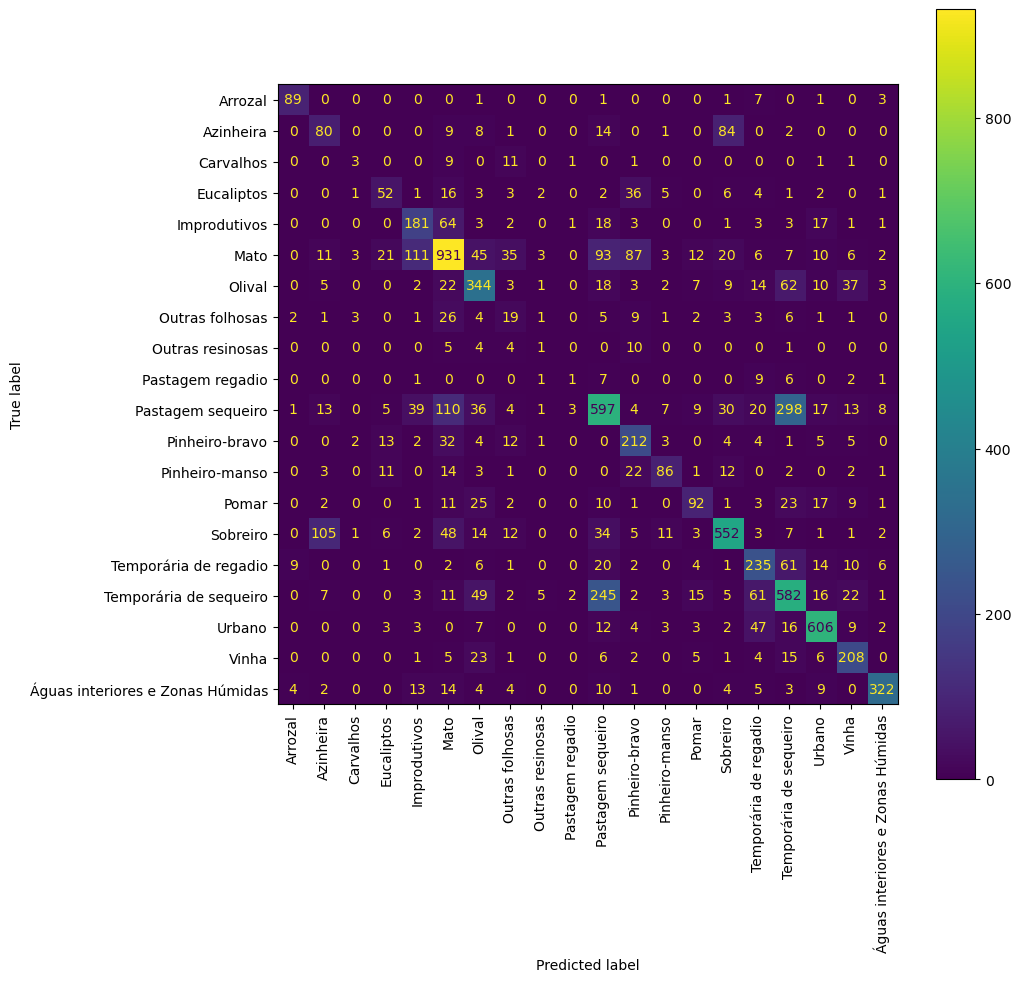

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(t, p)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10,10))
cm_disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [17]:
l, a = evaluate(model, test_loader, criterion)
print(f"Loss: {l}, Acc: {a}")

Loss: 2.3240293927233795, Acc: 0.5887513520009614


In [12]:
wandb.finish()

epoch,▁▂▄▅▇█
train_acc,▃█▃▂▁▁
train_loss,█▁▄▄▅▅
val_acc,▁█▄▁▄▁
val_loss,█▁▇█▇▇
epoch,5
train_acc,0.15677
train_loss,2.5821
val_acc,0.14602
val_loss,2.57332


In [16]:


val_loss, val_accuracy = evaluate(model, val_loader, criterion)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 2.8770, Validation Accuracy: 0.5905


In [ ]:
#TODO:
#check how to accelerate training - hypothesis is that loading the batches is slowing things down
#check if the image can be opened and loaded to the gpu (with rasterio)
#check if the batches can be loaded more efficiently (e.g. load the next batch when processing the present)
#verify is things are being done in the GPU

#a solution could be reading from disk in batches, instead of calling __getitem__ once for every batch idx.

#to think:
#the workers in the dataloader are actually opening a batch (32) each. so each iteration delivers "n" batches, "n" being
#the number of workers.
#it may be more beneficial if a worker opened an image (to generate a crop), then multiple workers would be working to generate
#multiple crops, then the batch would be delivered more quickly